In [1]:
from datasets import get_dataset_config_names

In [2]:

xtreme_subsets = get_dataset_config_names("xtreme")
print(f" XTREME HAS {len(xtreme_subsets)} configurations")


 XTREME HAS 183 configurations


In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets

['PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en',
 'PAN-X.es',
 'PAN-X.et',
 'PAN-X.eu',
 'PAN-X.fa',
 'PAN-X.fi',
 'PAN-X.fr',
 'PAN-X.he',
 'PAN-X.hi',
 'PAN-X.hu',
 'PAN-X.id',
 'PAN-X.it',
 'PAN-X.ja',
 'PAN-X.jv',
 'PAN-X.ka',
 'PAN-X.kk',
 'PAN-X.ko',
 'PAN-X.ml',
 'PAN-X.mr',
 'PAN-X.ms',
 'PAN-X.my',
 'PAN-X.nl',
 'PAN-X.pt',
 'PAN-X.ru',
 'PAN-X.sw',
 'PAN-X.ta',
 'PAN-X.te',
 'PAN-X.th',
 'PAN-X.tl',
 'PAN-X.tr',
 'PAN-X.ur',
 'PAN-X.vi',
 'PAN-X.yo',
 'PAN-X.zh']

In [4]:

from collections import defaultdict
from datasets import DatasetDict
from datasets import load_dataset

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]


# Return a DatasetDict if a key does not exist
panx_ch = defaultdict(DatasetDict)


In [5]:

for lang, frac in zip(langs, fracs):
    #load monolingual corpus
    ds = load_dataset("xtreme", name = f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows))))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:

import pandas as pd

print(pd.DataFrame({lang : [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"]))

                                de    fr    it    en
Number of training examples  12580  4580  1680  1180


In [7]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}:{value}")

tokens:['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags:[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs:['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [8]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}:{value}")

tokens:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags:Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None), length=-1, id=None)
langs:Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [9]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
tags

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None)

In [10]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/12580 [00:00<?, ?ex/s]

In [11]:
de_example = panx_de["train"][0]
for key, value in de_example.items():
    print(f"{key}:{value}")
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens', 'Tags'])

tokens:['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags:[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs:['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']
ner_tags_str:['O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O', 'O', 'B-LOC', 'B-LOC', 'I-LOC', 'O']


,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [12]:
from collections import Counter
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient='index')

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


In [13]:
from transformers import AutoTokenizer

In [14]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
bert_tokens

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']

In [16]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

In [17]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [18]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load Model Body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids= None, labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encode representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)


In [19]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
from transformers import AutoConfig
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels = tags.num_classes,
                                         id2label = index2tag, label2id = tag2index)
xlmr_config

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-ORG": 4,
    "I-PER": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [20]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index = ["Tokens", "Input IDs"])

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifie

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [21]:
print(device)

cuda


In [22]:
outputs  = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim = -1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f" Shape of outputs:{outputs.shape}")

Number of tokens in sequence: 10
 Shape of outputs:torch.Size([1, 10, 7])


In [23]:
predictions

tensor([[1, 3, 3, 3, 3, 3, 3, 3, 3, 1]], device='cuda:0')

In [24]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index = ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-PER,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-ORG,B-PER


In [25]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens  = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens,preds], index = ["Tokens", "Tags"])


In [26]:
de_example

{'tokens': ['2.000',
  'Einwohnern',
  'an',
  'der',
  'Danziger',
  'Bucht',
  'in',
  'der',
  'polnischen',
  'Woiwodschaft',
  'Pommern',
  '.'],
 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags_str': ['O',
  'O',
  'O',
  'O',
  'B-LOC',
  'I-LOC',
  'O',
  'O',
  'B-LOC',
  'B-LOC',
  'I-LOC',
  'O']}

In [27]:
words, labels  = de_example["tokens"], de_example["ner_tags"]


In [28]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
print(tokenized_input)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [29]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens","Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [30]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx==previous_word_idx:
        label_ids.append(-100)
    elif word_idx!=previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [31]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index = idx)
        previous_word_idx = None
        label_ids  = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [32]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched = True,
                        remove_columns = ['langs','ner_tags','tokens'])

In [33]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [34]:
from seqeval.metrics import classification_report
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
              ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
              ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [42]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis = 2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [],[]
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list


In [43]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetunde-panx-de"
training_args = TrainingArguments(
                output_dir = model_name, log_level = "error", num_train_epochs = num_epochs,
                per_device_train_batch_size = batch_size,
                per_device_eval_batch_size = batch_size, evaluation_strategy = "epoch",
                save_steps = 1e6, weight_decay = 0.01, disable_tqdm=False,
                logging_steps = logging_steps, push_to_hub=False)

In [44]:
from huggingface_hub import notebook_login

In [45]:
from seqeval.metrics import f1_score
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}


In [46]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [47]:
def model_init():
    return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config = xlmr_config).to(device))

In [48]:
from transformers import Trainer
trainer = Trainer(model_init = model_init, args = training_args,
                  data_collator = data_collator, compute_metrics=compute_metrics,
                  train_dataset = panx_de_encoded['train'],
                  eval_dataset = panx_de_encoded["validation"],
                  tokenizer = xlmr_tokenizer)

In [49]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1575, training_loss=0.15466361289932615, metrics={'train_runtime': 136.1023, 'train_samples_per_second': 277.292, 'train_steps_per_second': 11.572, 'total_flos': 863012377186080.0, 'train_loss': 0.15466361289932615, 'epoch': 3.0})

In [50]:
text_de = "Jeff Dean ist ein Infortmatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁In,fort,matik,er,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [51]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch  = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis = -1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction = "none")
    loss = loss.view(len(input_ids),-1).cpu().numpy()
    return {"loss":loss, "predicted_label":predicted_label}

valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

In [52]:
df.head()

,attention_mask,input_ids,labels,loss,predicted_label
0,"[1, 1, 1, 1, 1, 1, 1]","[0, 10699, 11, 15, 16104, 1388, 2]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.010540293, 0.0, 0.008063147, 0.0065919...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[-100, 0, -100, -100, -100, -100, 3, -100, -10...","[0.0, 0.00017855957, 0.0, 0.0, 0.0, 0.0, 0.370...","[4, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[-100, 0, 0, 0, 0, 3, -100, -100, 0, -100, 0, ...","[0.0, 0.00033158527, 0.00014768941, 0.00018618...","[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[-100, 0, 0, 0, 5, -100, 0, 0, -100]","[0.0, 0.00016163473, 0.00016819016, 0.00017760...","[5, 0, 0, 0, 5, 6, 0, 0, 5, 5, 5, 5, 5, 5, 5, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[-100, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 3, ...","[0.0, 0.000116937474, 0.00010609064, 0.0001410...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, ..."


In [53]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [54]:
index2tag[-100] = "IGN"
df["input_tokens"] = df['input_ids'].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x : [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x : [index2tag[i] for i in x])
df["loss"] = df.apply(lambda x :x['loss'][:len(x['input_ids'])], axis=1)
df["predicted_label"] = df.apply(lambda x :x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(5)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1]","[0, 10699, 11, 15, 16104, 1388, 2]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.010540293, 0.0, 0.008063147, 0.0065919...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[0.0, 0.00017855957, 0.0, 0.0, 0.0, 0.0, 0.370...","[I-ORG, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[IGN, O, O, O, O, B-ORG, IGN, IGN, O, IGN, O, ...","[0.0, 0.00033158527, 0.00014768941, 0.00018618...","[O, O, O, O, O, B-ORG, O, O, O, O, O, O, O, O]","[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, t..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[IGN, O, O, O, B-LOC, IGN, O, O, IGN]","[0.0, 0.00016163473, 0.00016819016, 0.00017760...","[B-LOC, O, O, O, B-LOC, I-LOC, O, O, B-LOC]","[<s>, ▁**, ▁', ▁'', ▁, Bretagne, ▁'', ▁', </s>]"
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[IGN, O, O, O, O, O, O, O, IGN, O, O, O, B-ORG...","[0.0, 0.000116937474, 0.00010609064, 0.0001410...","[O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-...","[<s>, ▁Nach, ▁einem, ▁Jahr, ▁bei, ▁diesem, ▁Ve..."


In [55]:
df_tokens  =df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(10)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,1,10699,B-ORG,0.01,B-ORG,▁Ham
0,1,15,I-ORG,0.01,I-ORG,▁(
0,1,16104,I-ORG,0.01,I-ORG,▁Unternehmen
0,1,1388,I-ORG,0.01,I-ORG,▁)
1,1,56530,O,0.00,O,▁WE
1,1,83982,B-ORG,0.37,B-ORG,▁Luz
1,1,10,I-ORG,0.44,I-ORG,▁a
1,1,57,I-ORG,0.46,I-ORG,▁sa
2,1,159093,O,0.00,O,▁entdeckt
2,1,165,O,0.00,O,▁und


In [56]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count","mean","sum"])
    .droplevel(level=0, axis =1) # Get rid of multi-level columns
    .sort_values(by = "sum", ascending = False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁in,▁der,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,989,1388,808,163,1171,246,246,2898,125
mean,0.04,0.14,0.08,0.13,0.65,0.08,0.3,0.29,0.02,0.46
sum,229.32,134.6,112.05,108.97,105.28,88.33,74.95,72.2,63.27,57.43


In [57]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count","mean","sum"])
    .droplevel(level=0, axis =1) # Get rid of multi-level columns
    .sort_values(by = "sum", ascending = False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6
labels,I-ORG,B-ORG,O,B-LOC,I-LOC,B-PER,I-PER
count,3820,2683,43648,3172,1462,2893,4139
mean,0.5,0.64,0.03,0.34,0.63,0.27,0.18
sum,1924.97,1714.97,1464.06,1067.96,921.92,779.33,738.23


In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_preds, y_true, labels):
    cm  = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize = (6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax = ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

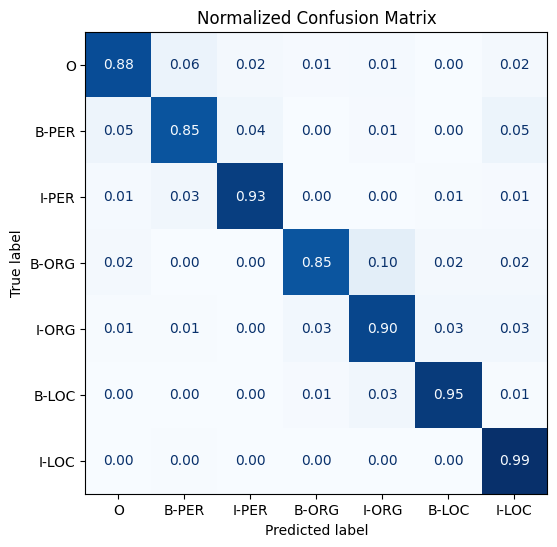

In [59]:
plot_confusion_matrix(df_tokens['labels'], df_tokens["predicted_label"], tags.names)

In [60]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [],[],[],[]
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens":tokens, "labels":labels,
                               "preds":preds, "losses":losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by = "total_loss", ascending=False).head(3)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.97,0.00,0.00,6.29,9.41,9.47,7.30,0.00,8.11,8.76,8.09,7.12,4.94,0.00,0.00,0.02,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,B-LOC
losses,0.00,0.00,2.20,0.00,0.00,0.00,9.51,9.38,6.37,7.32,7.56,0.00,7.68,7.73,0.00,8.41,8.33,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.41,5.21,5.63,0.00,5.33,0.00,5.12,0.00,4.80,5.01,5.83,5.80,5.07,5.11,0.00


In [61]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.02,0.02,0.00,0.02,0.00


In [62]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [63]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1_score of [de] model on [de] dataset:{f1_scores['de']['de']:.3f}")

F1_score of [de] model on [de] dataset:0.867


In [64]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])
    

In [65]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1_score of [de] model on [fr] dataset:{f1_scores['de']['fr']:.3f}")

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

F1_score of [de] model on [fr] dataset:0.698


In [66]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [it] dataset: 0.670


In [67]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de] model on [en] dataset: 0.594


In [68]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds)//batch_size
    trainer = Trainer(model_init = model_init, args=training_args,
                      data_collator = data_collator, compute_metrics = compute_metrics,
                      train_dataset =train_ds, eval_dataset = valid_ds, tokenizer = xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="training completed!")
    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples":[len(train_ds)],"f1_score":[f1_score]})

In [69]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [70]:
metrics_df = train_on_subset(panx_fr_encoded,250)
metrics_df

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


,num_samples,f1_score
0,250,0.176828


In [71]:
for num_samples in [500,1000,2000,4000]:
    metrics_df = pd.concat([metrics_df, train_on_subset(panx_fr_encoded, num_samples)], ignore_index=True)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


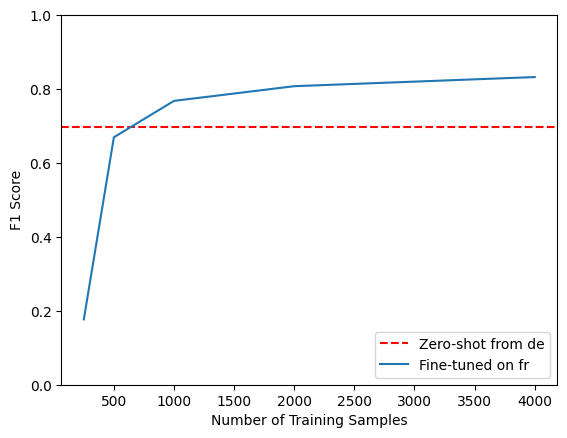

In [72]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [73]:
from datasets import concatenate_datasets
def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [74]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
        eval_dataset=panx_de_fr_encoded["validation"])
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=2145, training_loss=0.17659219950784893, metrics={'train_runtime': 186.4565, 'train_samples_per_second': 276.097, 'train_steps_per_second': 11.504, 'total_flos': 1140291491923584.0, 'train_loss': 0.17659219950784893, 'epoch': 3.0})

In [75]:
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [de] dataset: 0.870


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [fr] dataset: 0.860


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [it] dataset: 0.792


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [en] dataset: 0.678


In [76]:
corpora = [panx_de_encoded]
# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}" # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows) # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [77]:
corpora_encoded = concatenate_splits(corpora)

In [78]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"
trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=2505, training_loss=0.18582063127539591, metrics={'train_runtime': 224.96, 'train_samples_per_second': 266.981, 'train_steps_per_second': 11.135, 'total_flos': 1312991477886144.0, 'train_loss': 0.18582063127539591, 'epoch': 3.0})

In [79]:
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
scores_data =  {"de": f1_scores["de"],
                "each": {lang: f1_scores[lang][lang] for lang in langs},
                "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                            inplace=True)
f1_scores_df